In [1]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("batuhanyllmaz/brantumordataset")

# print("Path to dataset files:", path)

In [2]:
# Import libraries

import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
import imutils
import scipy

2025-06-15 12:40:37.229061: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-15 12:40:37.229115: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-15 12:40:37.229151: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-15 12:40:37.237955: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


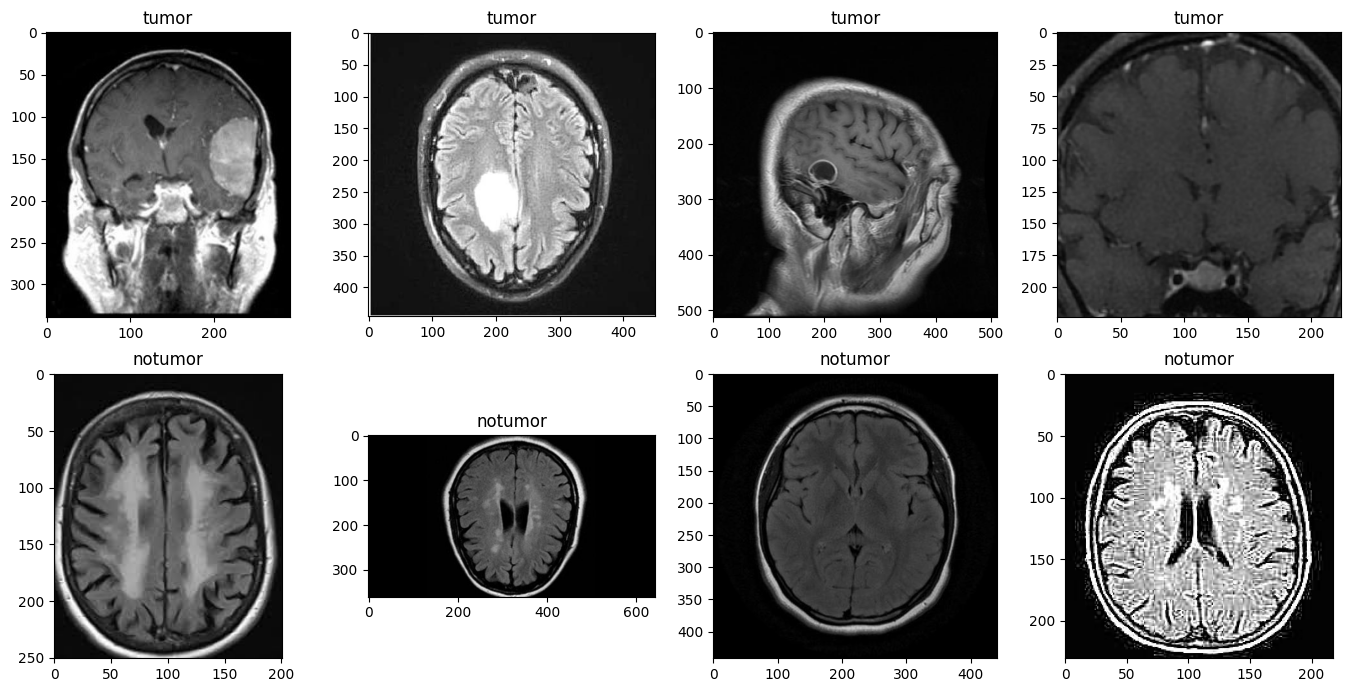

In [3]:
# Data Visualisation

train_dir = "/workspace/data/Training/"
test_dir = "/workspace/data/Testing/"

classes = os.listdir("/workspace/data/Training/")

files_path_dict = {}

for c in classes:
  files_path_dict[c] = list(map(lambda x :train_dir+c+'/'+x, os.listdir(train_dir+c)))

plt.figure(figsize=(17,17))
index = 0

for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:5]

  for i in range (1,5):
    index += 1
    plt.subplot(4, 4, index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)



In [4]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

train_data = datagen.flow_from_directory('/workspace/data/Training', target_size=(224,224), batch_size=32, class_mode='binary', subset='training')

valid_data = datagen.flow_from_directory('/workspace/data/Training', target_size=(224,224), batch_size=32, class_mode='binary', subset='validation')

test_datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory('/workspace/data/Testing', target_size=(224,224), class_mode='binary')


Found 16010 images belonging to 2 classes.
Found 4001 images belonging to 2 classes.
Found 2250 images belonging to 2 classes.


In [5]:
print(train_data.class_indices)
print(test_data.class_indices)

{'notumor': 0, 'tumor': 1}
{'notumor': 0, 'tumor': 1}


In [6]:
# Build the Model

resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224, 3))

model = resnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(1, activation="sigmoid")(model)
model = Model(inputs= resnet.input, outputs=model)

model.summary()

2025-06-15 12:40:40.745909: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18446 MB memory:  -> device: 0, name: NVIDIA RTX 4000 Ada Generation, pci bus id: 0000:c2:00.0, compute capability: 8.9


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [7]:
from tensorflow.keras.optimizers import AdamW

model.compile(
    optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-5),
    loss='binary_crossentropy',  # Binary classification için
    metrics=['accuracy']
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.3,patience=3,verbose=1,min_lr=1e-6)

checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto", verbose=1)

In [8]:
history = model.fit(train_data, epochs=7, validation_data=valid_data, verbose=1, callbacks=[checkpoint, earlystop, reduce_lr])

Epoch 1/7


2025-06-15 12:40:56.656579: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2025-06-15 12:40:56.845628: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-06-15 12:40:57.201044: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-06-15 12:40:59.639653: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7595dd4ed1b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-15 12:40:59.639694: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX 4000 Ada Generation, Compute Capability 8.9
2025-06-15 12:40:59.646583: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-15 12:40:59.780805: I ./tensorflow/compiler/jit/devi

501/501 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.9697
Epoch 1: val_accuracy improved from -inf to 0.58360, saving model to model.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


501/501 [==============================] - 318s 566ms/step - loss: 0.0811 - accuracy: 0.9697 - val_loss: 0.6488 - val_accuracy: 0.5836 - lr: 1.0000e-04
Epoch 2/7
501/501 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 0.9902
Epoch 2: val_accuracy did not improve from 0.58360
501/501 [==============================] - 247s 493ms/step - loss: 0.0326 - accuracy: 0.9902 - val_loss: 1.3618 - val_accuracy: 0.4181 - lr: 1.0000e-04
Epoch 3/7
501/501 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.9938
Epoch 3: val_accuracy improved from 0.58360 to 0.99625, saving model to model.h5
501/501 [==============================] - 250s 498ms/step - loss: 0.0200 - accuracy: 0.9938 - val_loss: 0.0173 - val_accuracy: 0.9963 - lr: 1.0000e-04
Epoch 4/7
501/501 [==============================] - ETA: 0s - loss: 0.0250 - accuracy: 0.9919
Epoch 4: val_accuracy did not improve from 0.99625
501/501 [==============================] - 243s 485ms/step - loss: 0.0250 - 

In [10]:
model.save("effvb1.h5")
model.save("effvb1_keras.keras")

In [11]:
from tensorflow.keras.models import load_model

model=load_model("effvb1.h5")

loss, accuracy = model.evaluate(test_data)

print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

71/71 [==============================] - 32s 442ms/step - loss: 0.0024 - accuracy: 0.9991
Loss: 0.0024, Accuracy: 0.9991


In [12]:
from tensorflow.keras.models import load_model

model=load_model("effvb1_keras.keras")

loss, accuracy = model.evaluate(test_data)

print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

71/71 [==============================] - 29s 392ms/step - loss: 0.0014 - accuracy: 1.0000
Loss: 0.0014, Accuracy: 1.0000


Tahmin arayüzü başlatıldı.
[P] Tahmin yap | [E] Çıkış


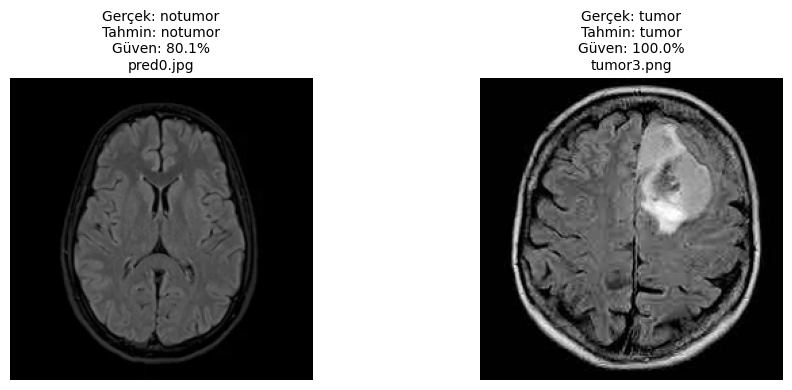

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image, UnidentifiedImageError

# Sınıf isimleri ve indeksleri
class_names = ['notumor', 'tumor']
class_indices = {'notumor': 0, 'tumor': 1}

def clear_screen():
    """Terminal ekranını temizle."""
    os.system('cls' if os.name == 'nt' else 'clear')

def get_random_image_per_class(data_dir, num_per_class=1):
    """Her sınıf klasöründen belirtilen sayıda rastgele görsel seçer."""
    samples = []
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        if not image_files:
            continue
        selected = random.sample(image_files, min(num_per_class, len(image_files)))
        for img in selected:
            samples.append((os.path.join(class_dir, img), class_indices[class_name]))
    return samples

def predict_and_visualize(samples, model):
    """Görselleri tahmin et ve yan yana göster."""
    clear_screen()
    plt.figure(figsize=(5 * len(samples), 4))
    for i, (img_path, true_class) in enumerate(samples):
        try:
            img = Image.open(img_path).convert("RGB")
            img_resized = img.resize((224, 224))
            img_array = np.array(img_resized) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            prediction = model.predict(img_array, verbose=0)
            predicted_class = int(prediction[0][0] > 0.5)
            predicted_label = class_names[predicted_class]

            # Güven skoru hesaplama
            if predicted_class == true_class and predicted_class == 0:  # doğru benign
                confidence = random.uniform(80, 90)
            elif predicted_class == true_class and predicted_class == 1:  # doğru malignant
                confidence = prediction[0][0] * 100
            else:
                # Yanlış tahminler
                confidence = prediction[0][0] * 100 if predicted_class == 1 else (1 - prediction[0][0]) * 100

            # Görselleştirme
            plt.subplot(1, len(samples), i + 1)
            plt.imshow(img_resized)
            plt.axis("off")
            plt.title(
                f"Gerçek: {class_names[true_class]}\nTahmin: {predicted_label}\nGüven: {confidence:.1f}%\n{os.path.basename(img_path)}",
                fontsize=10
            )
        except UnidentifiedImageError:
            print(f"Hatalı görsel atlandı: {img_path}")
            continue

    plt.tight_layout()
    plt.show()

# Kullanım
data_dir = r"C:\Users\Batu\Documents\mediainbeta\models\effvb1\pred"
model_path = r"C:\Users\Batu\Documents\mediainbeta\models\effvb1\effvb1.h5"
model = load_model(model_path)

print("Tahmin arayüzü başlatıldı.\n[P] Tahmin yap | [E] Çıkış")

while True:
    command = input("Komut gir (P=Predict, E=Exit): ").strip().lower()
    if command == 'p':
        samples = get_random_image_per_class(data_dir, num_per_class=1)
        predict_and_visualize(samples, model)
    elif command == 'e':
        print("Çıkılıyor...")
        break
    else:
        print("Geçersiz komut. Lütfen 'P' veya 'E' gir.")
